# IN3050/IN4050 Mandatory Assignment 3: Unsupervised Learning

**Name:** Bendik Selvaag-Hagen

**Username:** bendikse

### Rules

Before you begin the exercise, review the rules at this website: https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html , in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo" https://www.uio.no/english/about/regulations/studies/studies-examinations/routines-cheating.html By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, April 21, 2023, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs.

If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the exercise
This exercise has three parts. The first part is focused on Principal Component Analysis (PCA). You will go through some basic theory, and implent PCA from scratch to do compression and visualization of data.

The second part focuses on clustering using K-means. You will use `scikit-learn` to run K-means clustering, and use PCA to visualize the results.

The last part ties supervised and unsupervised learning together in an effort to evaluate the output of K-means using a logistic regression for multi-class classification approach.

The master students will also have to do one extra part about tuning PCA to balance compression with information lost.


### Tools
You may freely use code from the weekly exercises and the published solutions. In the first part about PCA you may **NOT** use ML libraries like `scikit-learn`. In the K-means part and beyond we encurage the use of `scikit-learn` to iterate quickly on the problems.

### Beware
This is a new assignment. There might occur typos or ambiguities. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your
own and explain them!

# Principal Component Analysis (PCA)
In this section, you will work with the PCA algorithm in order to understand its definition and explore its uses.

## Implementation: how is PCA implemented?
Here we implement the basic steps of PCA and we assemble them.

### Importing libraries
We start importing the *numpy* library for performing matrix computations, the *pyplot* library for plotting data, and the *syntheticdata* module to import synthetic data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import syntheticdata

### Centering the Data
Implement a function with the following signature to center the data as explained in *Marsland*.

In [101]:
def center_data(A):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    #
    # OUTPUT:
    # X    [NxM] numpy centered data matrix (N samples, M features)

    mean_a = np.mean(A, axis=0)
    A -= mean_a
    return A

Test your function checking the following assertion on *testcase*:

In [102]:
testcase = np.array([[3.,11.,4.3],[4.,5.,4.3],[5.,17.,4.5],[4,13.,4.4]])
answer = np.array([[-1.,-0.5,-0.075],[0.,-6.5,-0.075],[1.,5.5,0.125],[0.,1.5,0.025]])
np.testing.assert_array_almost_equal(center_data(testcase), answer)

### Computing Covariance Matrix
Implement a function with the following signature to compute the covariance matrix as explained in *Marsland*.

In [71]:
def compute_covariance_matrix(A):
    # INPUT:
    # A    [NxM] centered numpy data matrix (N samples, M features)
    #
    # OUTPUT:
    # C    [MxM] numpy covariance matrix (M features, M features)
    #
    # Do not apply centering here. We assume that A is centered before this function is called.
    
    C = np.cov(A, rowvar=False)
    
    return C

Test your function checking the following assertion on *testcase*:

In [72]:
testcase = center_data(np.array([[22.,11.,5.5],[10.,5.,2.5],[34.,17.,8.5],[28.,14.,7]]))
answer = np.array([[580.,290.,145.],[290.,145.,72.5],[145.,72.5,36.25]])

# Depending on implementation the scale can be different:
to_test = compute_covariance_matrix(testcase)

answer = answer/answer[0, 0]
to_test = to_test/to_test[0, 0]

np.testing.assert_array_almost_equal(to_test, answer)

### Computing eigenvalues and eigenvectors
Use the linear algebra package of `numpy` and its function `np.linalg.eig()` to compute eigenvalues and eigenvectors. Notice that we take the real part of the eigenvectors and eigenvalues. The covriance matrix *should* be a symmetric matrix, but the actual implementation in `compute_covariance_matrix()` can lead to small round off errors that lead to tiny imaginary additions to the eigenvalues and eigenvectors. These are purely numerical artifacts that we can safely remove.

**Note:** If you decide to NOT use `np.linalg.eig()` you must make sure that the eigenvalues you compute are of unit lenght!

In [73]:
def compute_eigenvalue_eigenvectors(A):
    # INPUT:
    # A    [DxD] numpy matrix
    #
    # OUTPUT:
    # eigval    [D] numpy vector of eigenvalues
    # eigvec    [DxD] numpy array of eigenvectors
    
    eigval, eigvec = np.linalg.eig(A)
    
    # Numerical roundoff can lead to (tiny) imaginary parts. We correct that here.
    eigval = np.real(eigval)
    eigvec = np.real(eigvec)
    
    return eigval, eigvec

Test your function checking the following assertion on *testcase*:

In [74]:
testcase = np.array([[2,0,0],[0,5,0],[0,0,3]])
answer1 = np.array([2.,5.,3.])
answer2 = np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])
x,y = compute_eigenvalue_eigenvectors(testcase)
np.testing.assert_array_almost_equal(x, answer1)
np.testing.assert_array_almost_equal(y, answer2)

### Sorting eigenvalues and eigenvectors
Implement a function with the following signature to sort eigenvalues and eigenvectors as explained in *Marsland*.

Remember that eigenvalue *eigval[i]* corresponds to eigenvector *eigvec[:,i]*.

In [76]:
def sort_eigenvalue_eigenvectors(eigval, eigvec):
    # INPUT:
    # eigval    [D] numpy vector of eigenvalues
    # eigvec    [DxD] numpy array of eigenvectors
    #
    # OUTPUT:
    # sorted_eigval    [D] numpy vector of eigenvalues
    # sorted_eigvec    [DxD] numpy array of eigenvectors
    sorted_eigval = np.copy(eigval)
    sorted_eigvec = np.copy(eigvec)
    ind = (np.argsort(eigval))    
    for i in range(len(ind)):
        a = ind[i]
        sorted_eigval[i] = eigval[a]
        sorted_eigvec[:, i] = eigvec[:, a]
    sorted_eigval = np.flip(sorted_eigval)
    sorted_eigvec = np.flip(sorted_eigvec, axis=1)
    return sorted_eigval, sorted_eigvec


testcase = np.array([[2,0,0],[0,5,0],[0,0,3]])
x,y = compute_eigenvalue_eigenvectors(testcase)
x,y = sort_eigenvalue_eigenvectors(x,y)

Test your function checking the following assertion on *testcase*:

In [77]:
testcase = np.array([[2,0,0],[0,5,0],[0,0,3]])
answer1 = np.array([5.,3.,2.])
answer2 = np.array([[0.,0.,1.],[1.,0.,0.],[0.,1.,0.]])
x,y = compute_eigenvalue_eigenvectors(testcase)
x,y = sort_eigenvalue_eigenvectors(x,y)
np.testing.assert_array_almost_equal(x, answer1)
np.testing.assert_array_almost_equal(y, answer2)

### PCA Algorithm
Implement a function with the following signature to compute PCA as explained in *Marsland* using the functions implemented above.

In [96]:
def pca(A,m):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    # m    integer number denoting the number of learned features (m <= M)
    #
    # OUTPUT:
    # pca_eigvec    [Mxm] numpy matrix containing the eigenvectors (M dimensions, m eigenvectors)
    # P             [Nxm] numpy PCA data matrix (N samples, m features)

    A = center_data(A)
    C = compute_covariance_matrix(A)
    pca_eigval, pca_eigvec = compute_eigenvalue_eigenvectors(C)
    pca_sort_val, pca_sort_vec = sort_eigenvalue_eigenvectors(pca_eigval, pca_eigvec)

    pca_sort_vec = pca_sort_vec[:,:m]

    P = np.dot(pca_sort_vec.T, A.T)
    return pca_sort_vec, P.T
    
testcase = np.array([[22.,11.,5.5],[10.,5.,2.5],[34.,17.,8.5]])
x,y = pca(testcase,2)

Test your function checking the following assertion on *testcase*:

In [97]:
testcase = np.array([[22.,11.,5.5],[10.,5.,2.5],[34.,17.,8.5]])
x,y = pca(testcase,2)

import pickle
answer1_file = open('PCAanswer1.pkl','rb'); answer2_file = open('PCAanswer2.pkl','rb')
answer1 = pickle.load(answer1_file); answer2 = pickle.load(answer2_file)

test_arr_x = np.sum(np.abs(np.abs(x) - np.abs(answer1)), axis=0)
np.testing.assert_array_almost_equal(test_arr_x, np.zeros(2))


test_arr_y = np.sum(np.abs(np.abs(y) - np.abs(answer2)))
np.testing.assert_almost_equal(test_arr_y, 0)

## Understanding: how does PCA work?
We now use the PCA algorithm you implemented on a toy data set in order to understand its inner workings.

### Loading the data
The module *syntheticdata* provides a small synthetic dataset of dimension [100x2] (100 samples, 2 features).

In [111]:
X = syntheticdata.get_synthetic_data1()

### Visualizing the data
Visualize the synthetic data using the function *scatter()* from the *matplotlib* library.

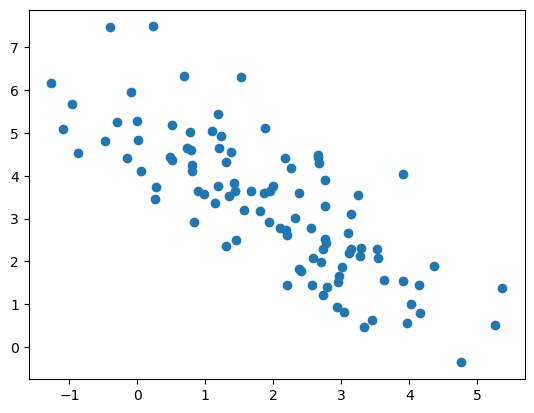

In [112]:
plt.scatter(X[:,0],X[:,1])

### Visualize the centered data
Notice that the data visualized above is not centered on the origin (0,0). Use the function defined above to center the data, and the replot it.

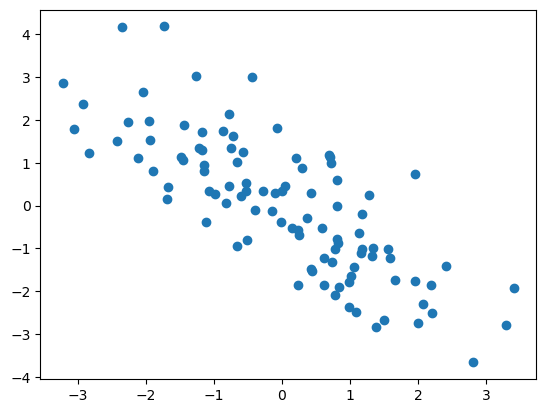

In [115]:
A = center_data(X)
plt.scatter(A[:,0],A[:,1])

### Visualize the first eigenvector
Visualize the vector defined by the first eigenvector.
To do this you need:
- Use the *PCA()* function to recover the eigenvectors
- Plot the centered data as done above 
- The first eigenvector is a 2D vector (x0,y0). This defines a vector with origin in (0,0) and head in (x0,y0). Use the function *plot()* from matplotlib to plot a line over the first eigenvector.

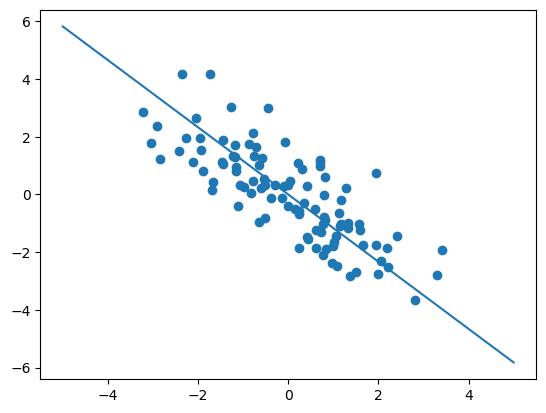

In [119]:
pca_eigvec, _ = pca(X,2)
first_eigvec = pca_eigvec[0]

plt.scatter(A[:,0],A[:,1])

x = np.linspace(-5, 5, 1000)
y = first_eigvec[1]/first_eigvec[0] * x
plt.plot(x,y)

### Visualize the PCA projection
Finally, use the *PCA()* algorithm to project on a single dimension and visualize the result using again the *scatter()* function.

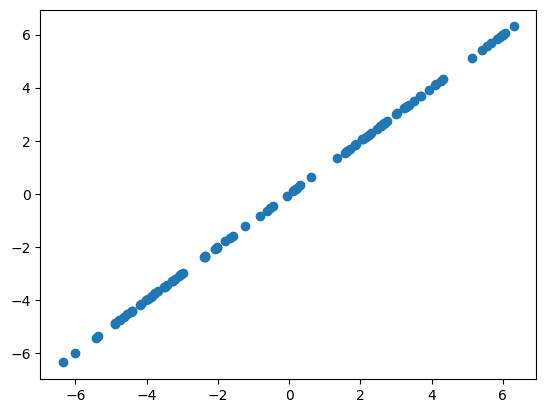

In [140]:
_,P = pca(X,1)

plt.scatter(P, P)

## Evaluation: when are the results of PCA sensible?
So far we have used PCA on synthetic data. Let us now imagine we are using PCA as a pre-processing step before a classification task. This is a common setup with high-dimensional data. We explore when the use of PCA is sensible.

### Loading the first set of labels
The function *get_synthetic_data_with_labels1()* from the module *syntethicdata* provides a first labeled dataset.

In [141]:
X,y = syntheticdata.get_synthetic_data_with_labels1()

### Running PCA
Process the data using the PCA algorithm and project it in one dimension. Plot the labeled data using *scatter()* before and after running PCA. Comment on the results.

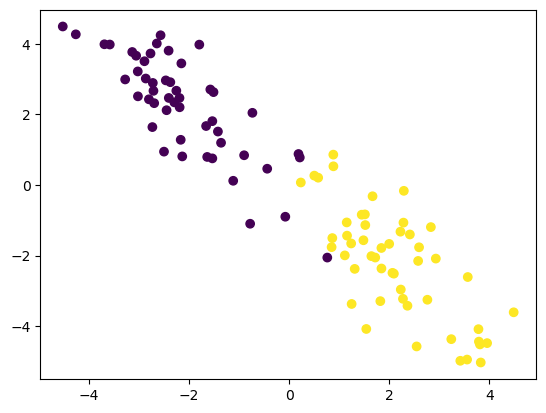

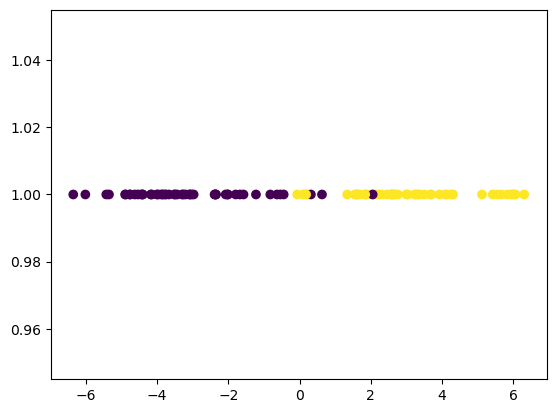

In [143]:
plt.scatter(X[:,0],X[:,1],c=y[:,0])

plt.figure()
_,P = pca(X,1)
plt.scatter(P,np.ones(P.shape[0]),c=y[:,0])

**Comment:** Enter your comment here.

### Loading the second set of labels
The function *get_synthetic_data_with_labels2()* from the module *syntethicdata* provides a second labeled dataset.

In [148]:
X,y = syntheticdata.get_synthetic_data_with_labels2()

### Running PCA
As before, process the data using the PCA algorithm and project it in one dimension. Plot the labeled data using *scatter()* before and after running PCA. Comment on the results.

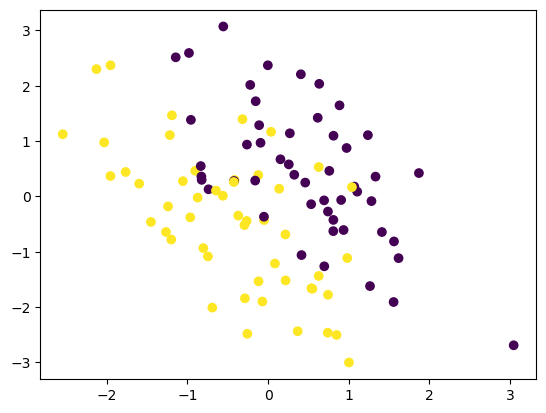

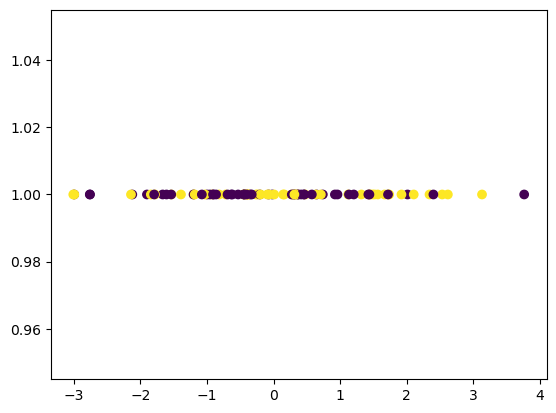

In [150]:
plt.scatter(X[:,0],X[:,1],c=y[:,0])

plt.figure()
_,P = pca(X,1)
plt.scatter(P,np.ones(P.shape[0]),c=y[:,0])

**Comment:** Enter your comment here.

How would the result change if you were to consider the second eigenvector? Or if you were to consider both eigenvectors?

**Answer**: Enter your answer here.

## Case study 1: PCA for visualization
We now consider the *iris* dataset, a simple collection of data (N=150) describing iris flowers with four (M=4) features. The features are: Sepal Length, Sepal Width, Petal Length and Petal Width. Each sample has a label, identifying each flower as one of 3 possible types of iris: Setosa, Versicolour, and Virginica.

Visualizing a 4-dimensional dataset is impossible; therefore we will use PCA to project our data in 2 dimensions and visualize it.

### Loading the data
The function *get_iris_data()* from the module *syntethicdata* returns the *iris* dataset. It returns a data matrix of dimension [150x4] and a label vector of dimension [150].

In [151]:
X,y = syntheticdata.get_iris_data()

### Visualizing the data by selecting features
Try to visualize the data (using label information) by randomly selecting two out of the four features of the data. You may try different pairs of features.

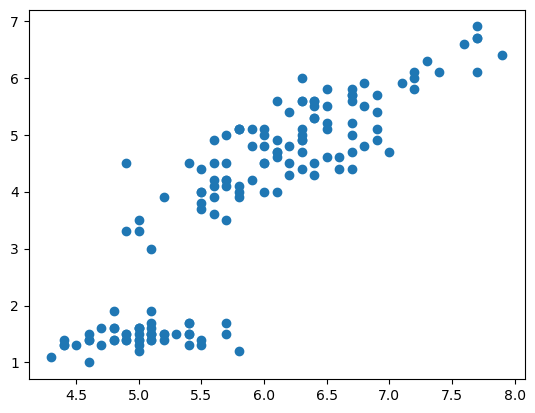

In [157]:
a = np.random.randint(0,1)
b = np.random.randint(2,3)

plt.scatter(X[:,a], X[:, b])

### Visualizing the data by PCA
Process the data using PCA and visualize it (using label information). Compare with the previous visualization and comment on the results.

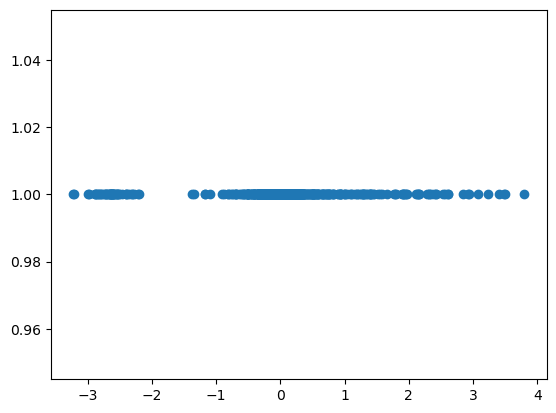

In [173]:
eig, P = pca(X, 4)

plt.scatter(P, np.ones(P.shape[:]))

**Comment:** Enter your comment here.

## Case study 2: PCA for compression
We now consider the *faces in the wild (lfw)* dataset, a collection of pictures (N=1280) of people. Each pixel in the image is a feature (M=2914).

### Loading the data
The function *get_lfw_data()* from the module *syntethicdata* returns the *lfw* dataset. It returns a data matrix of dimension [1280x2914] and a label vector of dimension [1280]. It also returns two parameters, $h$ and $w$, reporting the height and the width of the images (these parameters are necessary to plot the data samples as images). Beware, it might take some time to download the data. Be patient :) 

In [174]:
X,y,h,w = syntheticdata.get_lfw_data()

### Inspecting the data
Choose one datapoint to visualize (first coordinate of the matrix $X$) and use the function [imshow()](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html) to plot and inspect some of the pictures.

Notice that *imshow* receives as a first argument an image to be plot; the image must be provided as a rectangular matrix, therefore we reshape a sample from the matrix $X$ to have height $h$ and width $w$. The parameter *cmap* specifies the color coding; in our case we will visualize the image in black-and-white with different gradations of grey.

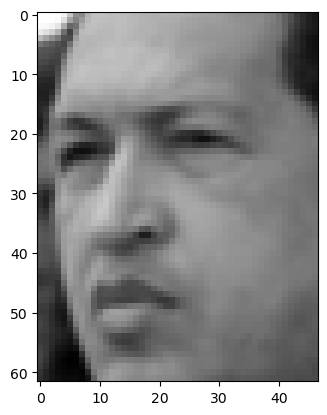

In [175]:
plt.imshow(X[0,:].reshape((h, w)), cmap=plt.cm.gray)

### Implementing a compression-decompression function
Implement a function that first uses PCA to project samples in low-dimensions, and the reconstruct the original image.

*Hint:* Most of the code is the same as the previous PCA() function you implemented. You may want to refer to *Marsland* to check out how reconstruction is performed.

In [176]:
def encode_decode_pca(A,m):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    # m    integer number denoting the number of learned features (m <= M)
    #
    # OUTPUT:
    # Ahat [NxM] numpy PCA reconstructed data matrix (N samples, M features)
    
    _,Ahat = pca(A,m)
    
    return Ahat

### Compressing and decompressing the data
Use the implemented function to encode and decode the data by projecting on a lower dimensional space of dimension 200 (m=200).

In [205]:
Xhat = (encode_decode_pca(X, 200))

### Inspecting the reconstructed data
Use the function *imshow* to plot and compare original and reconstructed pictures. Comment on the results.

In [210]:
print(type(Xhat))
plt.imshow(Xhat[0,:].reshape((h, w)), cmap=plt.cm.gray)

<class 'tuple'>


TypeError: tuple indices must be integers or slices, not tuple

**Comment:** Enter your comment here.

### Evaluating different compressions
Use the previous setup to generate compressed images using different values of low dimensions in the PCA algorithm (e.g.: 100, 200, 500, 1000). Plot and comment on the results.

In [ ]:
plt.imshow(X[0,:].reshape((h, w)), cmap=plt.cm.gray)

plt.figure()
Xhat = encode_decode_pca(X,None)
plt.imshow(Xhat[0,:].reshape((h, w)), cmap=plt.cm.gray)

None

**Comment:** Enter your comment here.

## Master Students: PCA Tuning
If we use PCA for compression or decompression, it may be not trivial to decide how many dimensions to keep. In this section we review a principled way to decide how many dimensions to keep.

The number of dimensions to keep is the only *hyper-parameter* of PCA. A method designed to decide how many dimensions/eigenvectors is the *proportion of variance*:
$$ \textrm{POV}=\frac{\sum_{i=1}^{m}{\lambda_{i}}}{\sum_{j=1}^{M}{\lambda_{j}}}, $$
where $\lambda$ are eigenvalues, $M$ is the dimensionality of the original data, and $m$ is the chosen lower dimensionality. 

Using the $POV$ formula we may select a number $M$ of dimensions/eigenvalues so that the proportion of variance is, for instance, equal to 95%.

Implement a new PCA for encoding and decoding that receives in input not the number of dimensions for projection, but the amount of proportion of variance to be preserved.

In [ ]:
def encode_decode_pca_with_pov(A,p):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    # p    float number between 0 and 1 denoting the POV to be preserved
    #
    # OUTPUT:
    # Ahat [NxM] numpy PCA reconstructed data matrix (N samples, M features)
    # m    integer reporting the number of dimensions selected

    m = None
    Ahat = None
    
    return Ahat,m

Import the *lfw* dataset using the *get_lfw_data()* in *syntheticdata*. Use the implemented function to encode and decode the data by projecting on a lower dimensional space such that POV=0.9. Use the function *imshow* to plot and compare original and reconstructed pictures. Comment on the results.

In [ ]:
X,y,h,w = syntheticdata.get_lfw_data()

In [ ]:
Xhat,m = encode_decode_pca_with_pov(X,None)

In [ ]:
plt.imshow(X[0,:].reshape((h, w)), cmap=plt.cm.gray)
plt.figure()
plt.imshow(Xhat[0,:].reshape((h, w)), cmap=plt.cm.gray)

**Comment:** Enter your comment here.

# K-Means Clustering (Bachelor and master students)
In this section you will use the *k-means clustering* algorithm to perform unsupervised clustering. Then you will perform a qualitative assesment of the results.

### Importing scikit-learn library
We start importing the module *cluster.KMeans* from the standard machine learning library *scikit-learn*.

In [ ]:
from sklearn.cluster import KMeans

### Loading the data
We will use once again the *iris* data set. The function *get_iris_data()* from the module *syntethicdata* returns the *iris* dataset. It returns a data matrix of dimension [150x4] and a label vector of dimension [150].

In [ ]:
X,y = syntheticdata.get_iris_data()

### Projecting the data using PCA
To allow for visualization, we project our data in two dimensions as we did previously. This step is not necessary, and we may want to try to use *k-means* later without the PCA pre-processing. However, we use PCA, as this will allow for an easy visualization.

In [ ]:
_,P = None

### Running k-means
We will now consider the *iris* data set as an unlabeled set, and perform clustering to this unlabeled set. We can compare the results of the clustering to the lableled calsses.

Use the class *KMeans* to fit and predict the output of the *k-means* algorithm on the projected data. Run the algorithm using the following values of $k=\{2,3,4,5\}$. 

In [ ]:
KM = KMeans(None)
yhat2 = KM.fit_predict(P)

None

### Qualitative assessment
Plot the results of running the k-means algorithm, compare with the true labels, and comment.

In [ ]:
plt.scatter(P[:,0],P[:,1],c=None)
plt.title('k=2')

# Repeat for k=3, 4 and 5:
None

plt.figure()
plt.scatter(P[:,0],P[:,1],c=y)
plt.title('Original data')

**Comment:** Enter your comment here.

# Quantitative Assessment of K-Means (Bachelor and master students)

We used k-means for clustering and we assessed the results qualitatively by visualizing them. However, we often want to be able to measure in a quantitative way how good the clustering was. To do this, we will use a classification task to evaluate numerically the goodness of the representation learned via k-means.

Reload the *iris* dataset. Import a standard `LogisticRegression` classifier from the module `sklearn.linear_model`. Use the k-means representations learned previously (`yhat2,...,yhat5`) and the true label to train the classifier. Evaluate your model on the training data (we do not have a test set, so this procedure will assess the model fit instead of generalization) using the `accuracy_score()` function from the *sklearn.metrics* module. Plot a graph showing how the accuracy score varies when changing the value of k. Comment on the results.

- Train a Logistic regression model using the first two dimensions of the PCA of the iris data set as input, and the true classes as targets.
- Report the model fit/accuracy on the training set.
- For each value of K:
  - One-Hot-Encode the classes output by the K-means algorithm.
  - Train a Logistic regression model on the K-means classes as input vs the real classes as targets.
  - Calculate model fit/accuracy vs. value of K.
- Plot your results in a graph and comment on the K-means fit.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

None

**Comment:** Enter your comment here.

# Conclusions 

In this notebook we studied **unsupervised learning** considering two important and representative algorithms: **PCA** and **k-means**.

First, we implemented the PCA algorithm step by step; we then run the algorithm on synthetic data in order to see its working and evaluate when it may make sense to use it and when not. We then considered two typical uses of PCA: for **visualization** on the *iris* dataset, and for **compression-decompression** on the *lfw* dateset.

We then moved to consider the k-means algorithm. In this case we used the implementation provided by *scikit-learn* and we applied it to another prototypical unsupervised learning problem: **clustering**; we used *k-means* to process the *iris* dataset and we evaluated the results visually.

In the final part, we considered two additional questions that may arise when using the above algorithms. For PCA, we considered the problem of **selection of hyper-parameters**, that is, how we can select the hyper-parameter of ou algorithm in a reasonable fashion. For k-means, we considered the problem of the **quantitative evaluation** of our results, that is, how can we measure the performance or usefulness of our algorithms. 